In [4]:
import pandas as pd 
import numpy as np 
import pickle
import os 
from scipy.stats import norm
os.chdir(r'C:\Users\User\Desktop\Optimization\Algorithms\Genetic Algorithm')
from ga import *
os.chdir(r'C:\Users\User\Desktop\Optimization\Algorithms\Bayesian MCMC')
from BayesianOptimizer import *
import time
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt


In [5]:
def obj(percentage_miss_strength):
    obj_func = []
    for i in percentage_miss_strength:
        # Compute objective function value
        obj_func.append(regional_obj_fatality(i))
    return np.array(obj_func)

def total_strength(percentage_miss_strength, sampled_building_info, Sa_map, miss_strength, IM_bin):
    '''
    This function is developed for compute the total strength added by algorithm
    '''
    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    cost_map = pd.DataFrame(np.zeros(Sa_map.shape))
    for k in range(8):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Total Force'] = np.multiply(percentage_miss_strength[k], miss_strength['X Diff']) + np.multiply(percentage_miss_strength[k], miss_strength['Z Diff'])
        for j in range(Sa_map.shape[1]):
            sub_Sa_map = Sa_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]), :].iloc[:,j]
            if sub_Sa_map.shape[0] == 0: 
                continue
            sub_building_map = buildings.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]),:]
            building_cost = sub_building_map.merge(temp)
            cost_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]), j] = building_cost.iloc[:,1]

    total_cost =  cost_map.mean(axis = 1).sum()
    return total_cost

def summary_fatality(percentage_miss_strength):
    '''
    This function is developed for compute the total strength added by algorithm
    '''
    im_bin = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, float('inf')]
    retrof_ratio = {}
    prop = {}
    retrof_ds_ratio = {}
    retrof_ds_median = {}
    for i in range(1,9):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Xpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['X Diff']) + peak_strength['Xpeakstrength'], peak_strength['Xpeakstrength'])
        temp['Zpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['Z Diff']) + peak_strength['Zpeakstrength'], peak_strength['Zpeakstrength'])
        temp = pd.concat([temp,retrof_upper_limit]).min(level=0)
        retrof_ratio[i] = temp
        prop[i] = existing_prop.drop(columns=['Xpeakstrength', 'Zpeakstrength'])
        prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'], retrof_ratio[i]['Zpeakstrength']

        retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
        retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
        # Compute retrofitted buildings damage state medians 
        retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
        retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])

    region_fatality = compute_fatality(sampled_building_info, total_fatality, retrof_ds_median, sa_simulated, im_bin)
    individual_fatality = compute_individual_fatality(sampled_building_info, total_fatality, retrof_ds_median, sa_simulated, im_bin)
    return region_fatality, individual_fatality

def regional_obj_fatality(percentage_miss_strength):
    '''
    This function is developed for compute objective function corresponding to single set of value
    '''
    im_bin = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, float('inf')]
    retrof_ratio = {}
    prop = {}
    retrof_ds_ratio = {}
    retrof_ds_median = {}
    for i in range(1,9):
        temp = pd.DataFrame() 
        temp['Index'] = existing_prop['Index']
        temp['Xpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['X Diff']) + peak_strength['Xpeakstrength'], peak_strength['Xpeakstrength'])
        temp['Zpeakstrength'] = np.divide(np.multiply(percentage_miss_strength[i-1], missing_strength['Z Diff']) + peak_strength['Zpeakstrength'], peak_strength['Zpeakstrength'])
        temp = pd.concat([temp,retrof_upper_limit]).min(level=0)
        retrof_ratio[i] = temp
        prop[i] = existing_prop.drop(columns=['Xpeakstrength', 'Zpeakstrength'])
        prop[i]['Xpeakstrength'], prop[i]['Zpeakstrength'] = retrof_ratio[i]['Xpeakstrength'], retrof_ratio[i]['Zpeakstrength']

        retrof_ds_ratio[i] = pd.DataFrame(data = prop[i]['Index'])
        retrof_ds_ratio[i]['complete_ratio'] = retrof_complete_ratio.predict(prop[i].iloc[:,1:])
        # Compute retrofitted buildings damage state medians 
        retrof_ds_median[i] = pd.DataFrame(data = np.multiply(retrof_ds_ratio[i]['complete_ratio'],existing_ds['Complete']))
        retrof_ds_median[i].insert(0,'Index', retrof_ds_ratio[i]['Index'])

    region_fatality = compute_fatality(sampled_building_info, total_fatality, retrof_ds_median, sa_simulated, im_bin)

    # Compute penalty term
    region_penalty = penalty(sampled_building_info, percentage_miss_strength, w, pd.DataFrame(index=[1,2,3,4,5,6,7,8]), retrof_percent_range, 'single-building-cumulated-inverse')
    return -region_fatality - region_penalty


def compute_fatality(sampled_building_info, building_fatality, building_dsm, Sa_map, IM_bin):
    '''    
    This function is mainly used for computing regional earthquake losses given scenario
    sampled_building_info: assigned missing building information 
    building_loss: prototype archetype losses in each damage state 
    building_dsm: retrofitted prototype archetype damage state medians 
    Sa_map: ground shaking maps given scenario/event
    IM_bin: different retrofit strength is applied to different intensity bins
    '''

    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_fatality = buildings.merge(total_fatality)

    # Compute probability of complete damage at each site given each shake map
    ds_prob_map = pd.DataFrame(np.zeros(Sa_map.shape))

    # Loop over all shake maps
    for k in range(8):
        for j in range(Sa_map.shape[1]):
            sub_Sa_map = Sa_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]), :].iloc[:,j]
            if sub_Sa_map.shape[0] == 0: 
                continue
            sub_building_map = buildings.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]),:]
            building_ds_median = sub_building_map.merge(building_dsm[k+1])
            ds_prob_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]), j] = norm.cdf(np.log(sub_Sa_map.astype('float64')), loc = np.log(building_ds_median.iloc[:,1]), scale = 0.6)
    collapse_prob = ds_prob_map.mean(axis = 1)

    portfolio_fatality = np.multiply(collapse_prob,site_fatality.iloc[:,1]).sum().sum()
    return portfolio_fatality


def compute_individual_fatality(sampled_building_info, building_fatality, building_dsm, Sa_map, IM_bin):
    '''    
    This function is mainly used for computing regional earthquake losses given scenario
    sampled_building_info: assigned missing building information 
    building_loss: prototype archetype losses in each damage state 
    building_dsm: retrofitted prototype archetype damage state medians 
    Sa_map: ground shaking maps given scenario/event
    '''
    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_fatality = buildings.merge(total_fatality)

    # Compute probability of complete damage at each site given each shake map
    ds_prob_map = pd.DataFrame(np.zeros(Sa_map.shape))

    # Loop over all shake maps
    for k in range(8):
        for j in range(Sa_map.shape[1]):
            sub_Sa_map = Sa_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]), j]
            sub_building_map = buildings.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]),:]
            building_ds_median = sub_building_map.merge(building_dsm[k+1])
            ds_prob_map.loc[(Sa_map.iloc[:,j] < IM_bin[k+1]) & (Sa_map.iloc[:,j] > IM_bin[k]), j] = norm.cdf(np.log(sub_Sa_map), loc = np.log(building_ds_median.iloc[:,1]), scale = 0.6)
    collapse_prob = ds_prob_map.mean(axis = 1)

    individual_fatality = np.multiply(collapse_prob,site_fatality.iloc[:,1])

    return individual_fatality

def penalty(sampled_building_info, ratios, w, penalty_df, retrof_limit, penalty_type):

    if penalty_type == 'linear':
        penalty_df['penalty'] = np.multiply(w , np.sqrt(ratios**2)) # In this case, w is a 4x1 list 

    elif penalty_type == 'inverse':
        temp = np.divide(np.sqrt(w), retrof_limit[1]-ratios+0.0000001)
        penalty_df['penalty'] = temp**2 # In this case, w is a single number

    elif penalty_type == 'single-building-cumulated-inverse':
        shape = [307, 769, 1762, 3381, 3244, 1358, 915, 306]
        temp = np.divide(np.sqrt(w), retrof_limit[1]-ratios+0.0000001)
        penalty_df['penalty'] = np.multiply(shape, temp**2) # In this case, w is a single number  
        
    elif penalty_type == 'quadratic-inverse':
        temp = np.divide(w, np.multiply(ratios-retrof_limit[0]+0.0000001,retrof_limit[1]-ratios+0.0000001))
        penalty_df['penalty'] = temp # In this case, w is a single number
 
    return penalty_df['penalty'].sum()


def ordinance_fatality(sampled_building_info, building_fatality, building_dsm, Sa_map):
    '''    
    This function is mainly used for computing regional earthquake losses given scenario
    sampled_building_info: assigned missing building information 
    building_loss: prototype archetype losses in each damage state 
    building_dsm: retrofitted prototype archetype damage state medians 
    Sa_map: ground shaking maps given scenario/event
    '''
    buildings = pd.DataFrame(data = sampled_building_info['Index'])
    # Building collapse  at each location
    site_fatality = buildings.merge(building_fatality)

    # Building damage state median at each location 
    building_ds_median = buildings.merge(building_dsm)

    # Compute probability of complete damage at each site given each shake map
    ds_prob_map = pd.DataFrame(np.zeros(Sa_map.shape))
    # Loop over all shake maps
    for j in range(Sa_map.shape[1]):
        ds_prob_map.iloc[:,j] = norm.cdf(np.log(Sa_map.iloc[:,j]), loc = np.log(building_ds_median.iloc[:,1]), scale = 0.6)
    collapse_prob = ds_prob_map.mean(axis = 1)

    portfolio_fatality = np.multiply(collapse_prob,site_fatality.iloc[:,1]).sum().sum()
    
    return portfolio_fatality

In [6]:
# Load ML prediction models 
# os.chdir(r'C:\Users\User\Desktop\XGBoostPipline\Models\MixedTrainTest\Existing')
# existing_slight = pickle.load(open('Slight.pickle','rb'))
# existing_moderate = pickle.load(open('Moderate.pickle','rb'))
# existing_severe = pickle.load(open('Severe.pickle','rb'))
# existing_complete = pickle.load(open('Complete.pickle','rb'))

os.chdir(r'C:\Users\User\Desktop\XGBoostPipline\Models\MixedTrainTest\Retrofit')
# retrof_slight_ratio = pickle.load(open('Retrof_Slight_Ratio.pkl','rb'))
# retrof_moderate_ratio = pickle.load(open('Retrof_Moderate_Ratio.pkl','rb'))
# retrof_severe_ratio = pickle.load(open('Retrof_Severe_Ratio.pkl','rb'))
retrof_complete_ratio = pickle.load(open('Retrof_Complete_Ratio.pkl','rb'))

[12:18:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [7]:
# Sample unknown buildings 
def samplecase(OriginalData):
    InventoryData = OriginalData
    InventoryData = InventoryData.drop(columns = ['SMS'])
    for i in range(InventoryData.shape[0]):
        # Randomly assign number of stories
        if np.isnan(InventoryData.iloc[i,2]):
            InventoryData.iloc[i,2] = np.random.choice(np.arange(2, 4), p=[0.759, 0.241])
            
        # Randomly assign floor type          
        if pd.isnull(InventoryData.iloc[i,3]):
            InventoryData.iloc[i,3] = np.random.choice(np.arange(1, 5), p=[0.159, 0.011, 0.458, 0.372])
            
    
    
    InventoryData.loc[InventoryData['Story'] == 2,'Story'] = "2"
    InventoryData.loc[InventoryData['Story'] == 3,'Story'] = "3"
    
    InventoryData.loc[InventoryData['Type'] == 1,'Type'] = 'FWL1'
    InventoryData.loc[InventoryData['Type'] == 2,'Type'] = 'FWL2'
    InventoryData.loc[InventoryData['Type'] == 3,'Type'] = 'FWL3'
    InventoryData.loc[InventoryData['Type'] == 4,'Type'] = 'FWL4'
    
    InventoryData.loc[InventoryData['Type'] == 'FWL1','Type'] = 'L1'
    InventoryData.loc[InventoryData['Type'] == 'FWL2','Type'] = 'L2'
    InventoryData.loc[InventoryData['Type'] == 'FWL3','Type'] = 'L3'
    InventoryData.loc[InventoryData['Type'] == 'FWL4','Type'] = 'L4'
    
#     Randomly assign material type 
    mat = np.random.choice(np.arange(1, 3), size = InventoryData.shape[0], p=[0.5, 0.5])
    InventoryData['Material'] = mat
    
    InventoryData.loc[InventoryData['Material'] == 1,'Material'] = 'GWB'
    InventoryData.loc[InventoryData['Material'] == 2,'Material'] = 'HWS'
    
#     Randomly assign dimension 
    dim = np.random.choice(np.arange(1, 3), size = InventoryData.shape[0], p=[0.5, 0.5])
    InventoryData['Dimension'] = dim
    
#     Assign floor type
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X30'
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X30'
    
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '60X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '60X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*30*3
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '100X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L1') & (InventoryData['Dimension'] == '100X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*30*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X50'
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X50'
    
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*50*3
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L2') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*50*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == 1),'Dimension'] = '50X30'
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == 2),'Dimension'] = '80X30'
    
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '50X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 50*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '50X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 50*30*3
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '80X30') 
                      & (InventoryData['Story'] == '2'),'Area'] = 80*30*2
    InventoryData.loc[(InventoryData['Type'] == 'L3') & (InventoryData['Dimension'] == '80X30') 
                      & (InventoryData['Story'] == '3'),'Area'] = 80*30*3
    
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == 1),'Dimension'] = '60X50'
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == 2),'Dimension'] = '100X50'
    
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 60*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '60X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 60*50*3
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '2'),'Area'] = 100*50*2
    InventoryData.loc[(InventoryData['Type'] == 'L4') & (InventoryData['Dimension'] == '100X50') 
                      & (InventoryData['Story'] == '3'),'Area'] = 100*50*3

    InventoryData['Index'] = InventoryData['Type'] + '-' + InventoryData['Story'] + 'S-' + InventoryData['Dimension'].astype('str') + '-' + InventoryData['Material']
    
    #     Randomly assign repair cost
    InventoryData['Num_Units'] = (np.round(InventoryData['Area'].values/1000)).astype(int)
    Median_Cost = np.interp(InventoryData['Num_Units'],[4,30],[6250,4000])
    
    InventoryData['RepairCost'] = np.random.normal(Median_Cost,400)*InventoryData['Num_Units']
    
    return InventoryData

In [8]:
os.chdir(r'C:\Users\User\Desktop\Optimization\CollapseLoss_DBE')
OriginalBuildingInfo = pd.read_csv('LA Inventory.csv')

# Random assign unknown buildings
# sampled_building_info = samplecase(OriginalBuildingInfo)
sampled_building_info = pd.read_csv(r'C:\Users\User\Desktop\Optimization\CollapseLoss_DBE\sampled_building_info.csv') # use the same sampled building info to compare the results

# Optimize for the M7.1 senario
sa_simulated = pd.read_csv('DBEResults\Sa_simulated_real.csv', header = None)

# Read existing building damage state
existing_ds = pd.read_csv('building_ds.csv')

# Read existing building properties and pushover 
existing_prop = pd.read_csv('building_performance.csv')

# Read building configuration, which is mainly used for loss assessment 
building_config = pd.read_csv('building_configuration.csv')

# Read building losses
total_loss = pd.read_csv('ds_loss.csv')

# Read building fatality 
# total_fatality = pd.read_csv('fatality_rate.csv')
# Use complete loss as criteria: complete loss = building collapse loss + fatality loss ($2 million per fatality)
total_fatality = pd.read_csv('complete_loss.csv') 

# Read retrofit upper limit, which corresponding to NON SWOF building peak strength
retrof_upper_limit = pd.read_csv('UpperLimit.csv')

# Read missing strength
missing_strength = pd.read_csv('building_miss_strength.csv')

# Read existing building damage state medians
existing_ds = pd.read_csv('building_ds.csv')

# Existing pushover peak strength
peak_strength = pd.DataFrame()
peak_strength['Index'] = existing_prop['Index']
peak_strength['Xpeakstrength'] = np.multiply(existing_prop['SeismicWeight'], existing_prop['Xpeakstrength'])
peak_strength['Zpeakstrength'] = np.multiply(existing_prop['SeismicWeight'], existing_prop['Zpeakstrength'])

## Fatality Optimization

In [9]:
from bayes_opt import BayesianOptimization

def obj_func(a,b,c,d,e,f,g,h):
    p = [a,b,c,d,e,f,g,h]
    return regional_obj_fatality(p)
retrof_percent_range = np.array([[0]*8, [1]*8])
pbounds = {'a':(0, 1), 'b':(0, 1), 'c':(0, 1), 'd':(0, 1), 'e':(0, 1), 'f':(0, 1), 'g':(0, 1), 'h':(0, 1)}

In [11]:
W = [150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000]
x_best  = []
for w in W:
    optimizer = BayesianOptimization(f = obj_func,
                                    pbounds = pbounds)
    optimizer.maximize(init_points = 200, n_iter = 150)
    x_best.append(optimizer.max['params'])

668   |  0.7235   |  0.1167   |
|  253      | -1.035e+1 |  0.5706   |  0.6456   |  0.8152   |  0.8731   |  0.7613   |  0.4668   |  0.7235   |  0.1167   |
|  254      | -1.035e+1 |  0.5706   |  0.6456   |  0.8152   |  0.8731   |  0.7613   |  0.4668   |  0.7235   |  0.1167   |
|  255      | -1.035e+1 |  0.5706   |  0.6456   |  0.8152   |  0.8731   |  0.7613   |  0.4668   |  0.7235   |  0.1167   |
|  256      | -1.035e+1 |  0.5706   |  0.6456   |  0.8152   |  0.8731   |  0.7613   |  0.4668   |  0.7235   |  0.1167   |
|  257      | -1.035e+1 |  0.5706   |  0.6456   |  0.8152   |  0.8731   |  0.7613   |  0.4668   |  0.7235   |  0.1167   |
|  258      | -1.035e+1 |  0.5706   |  0.6456   |  0.8152   |  0.8731   |  0.7613   |  0.4668   |  0.7235   |  0.1167   |
|  259      | -1.035e+1 |  0.5706   |  0.6456   |  0.8152   |  0.8731   |  0.7613   |  0.4668   |  0.7235   |  0.1167   |
|  260      | -1.037e+1 |  0.3807   |  0.7453   |  0.4925   |  0.8123   |  0.8267   |  0.8793   |  0.2752   |  0.4

In [10]:
w = 100
optimizer = BayesianOptimization(f = obj_func,
                                pbounds = pbounds)
optimizer.probe(
    params={'a':1, 'b':1, 'c':1, 'd':1, 'e':1, 'f':1, 'g':1, 'h':1},
    lazy=True,
)
optimizer.maximize(init_points = 200, n_iter = 10)
timizer.max['params']

905   |  0.7757   |  0.94     |  0.2368   |
|  114      | -1.065e+1 |  0.8949   |  0.9004   |  0.8336   |  0.9524   |  0.979    |  0.4737   |  0.1224   |  0.2889   |
|  115      | -1.009e+1 |  0.824    |  0.09051  |  0.6251   |  0.9143   |  0.2239   |  0.6      |  0.8832   |  0.2165   |
|  116      | -1.295e+1 |  0.8646   |  0.237    |  0.5001   |  0.1054   |  0.1736   |  0.9927   |  0.481    |  0.8486   |
|  117      | -1.022e+1 |  0.8477   |  0.4755   |  0.4638   |  0.6406   |  0.002826 |  0.5867   |  0.7963   |  0.1125   |
|  118      | -1.024e+1 |  0.6014   |  0.4343   |  0.1359   |  0.4302   |  0.378    |  0.4394   |  0.4339   |  0.8307   |
|  119      | -1.053e+1 |  0.1447   |  0.7497   |  0.01216  |  0.1869   |  0.1271   |  0.5183   |  0.008441 |  0.6136   |
|  120      | -1.001e+1 |  0.965    |  0.8828   |  0.4678   |  0.7643   |  0.5516   |  0.1479   |  0.6691   |  0.6329   |
|  121      | -1.008e+1 |  0.7739   |  0.9576   |  0.1111   |  0.8467   |  0.6157   |  0.1484   |  0.2

NameError: name 'timizer' is not defined

In [8]:
optimizer.max['params']

{'a': 0.986378848253613,
 'b': 0.9871224866101861,
 'c': 0.9871053465880735,
 'd': 1.0,
 'e': 1.0,
 'f': 0.9863044536758555,
 'g': 0.98919205279358,
 'h': 0.9869887345562117}

## Post Processing

In [14]:
total_fatality_algorithm = []
total_cost = []
im_bin = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, float('inf')]
for x in x_best:
    a, b = summary_fatality(list(x.values()))
    total_fatality_algorithm.append(a)
    total_cost.append(total_strength(list(x.values()), sampled_building_info, sa_simulated, missing_strength, im_bin))



In [20]:
total_cost

[27495.135228647974,
 27700.361980463458,
 25687.173764665138,
 22175.946721263528,
 27408.188916561077,
 27022.587239965796,
 26604.89918096859,
 23128.666843262054]

In [46]:
of

9138606928.429668

In [16]:
ordinance_ds = pd.read_csv(r'C:\Users\User\Desktop\Optimization\CollapseLoss_DBE\ordinance_building_ds.csv')
ordinance_ds = ordinance_ds.drop(columns=['Slight', 'Moderate', 'Severe'])
of = ordinance_fatality(sampled_building_info, total_fatality, ordinance_ds, sa_simulated)
ef = ordinance_fatality(sampled_building_info, total_fatality, existing_ds.drop(columns=['Slight', 'Moderate', 'Severe']), sa_simulated)
ordinance_strength = pd.read_csv(r'C:\Users\User\Desktop\Optimization\CollapseLoss_DBE\ordinance_inc_strength.csv')
merged_info = sampled_building_info.merge(ordinance_strength, left_on='Index', right_on='Index')
oc = merged_info['X Inc Force'].sum() + merged_info['Z Inc Force'].sum()
ordinance_reduction = 1 - of/ef
algorithm_reduction = [1-x/ef for x in total_fatality_algorithm]

In [57]:
total_fatality

,Index,Complete Loss
0,L1-2S-60X30-GWB,947738
1,L1-3S-60X30-GWB,1425796
2,L1-2S-100X30-GWB,1581402
3,L1-3S-100X30-GWB,2376744
4,L1-2S-60X30-HWS,946764
5,L1-3S-60X30-HWS,1424298
6,L1-2S-100X30-HWS,1579900
7,L1-3S-100X30-HWS,2374634
8,L2-2S-60X50-GWB,1580252
9,L2-3S-60X50-GWB,2375412


(0.7, 1.5)

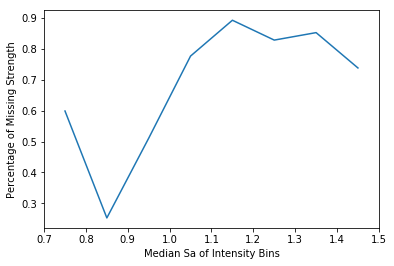

In [32]:
plt.plot([0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45], list(x_best[0].values()))
plt.xlabel('Median Sa of Intensity Bins')
plt.ylabel('Percentage of Missing Strength')
plt.xlim([0.7, 1.5])

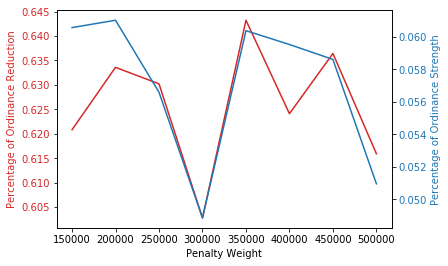

In [47]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Penalty Weight')
ax1.set_ylabel('Percentage of Ordinance Reduction', color=color)
ax1.plot(W, np.divide(algorithm_reduction, ordinance_reduction), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Percentage of Ordinance Strength', color=color)  # we already handled the x-label with ax1
ax2.plot(W, np.divide(total_cost, oc), color=color)
ax2.tick_params(axis='y', labelcolor=color)

(0.7, 1.5)

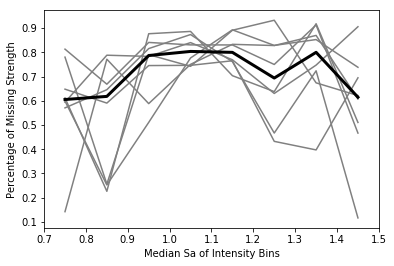

In [56]:
x_val = [] 
for x in x_best:
    plt.plot([0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45], list(x.values()), color='grey')
    x_val.append(list(x.values()))
plt.plot([0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45], np.median(x_val, axis = 0), color = 'black', linewidth = 3)
plt.xlabel('Median Sa of Intensity Bins')
plt.ylabel('Percentage of Missing Strength')
plt.xlim([0.7, 1.5])